In [124]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [125]:
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam

In [126]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('data/training_set/Parasitized')

In [127]:
train_paths_parasitized[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [128]:
train_paths_parasitized = ['data/training_set/Parasitized/' + i for i in train_paths_parasitized]

In [129]:
train_paths_uninfected += os.listdir('data/training_set/Uninfected')
train_paths_uninfected = ['data/training_set/Uninfected/' + i for i in train_paths_uninfected]

In [130]:
train_paths_uninfected[0]

'data/training_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [131]:

paths = train_paths_parasitized + train_paths_uninfected
# paths.remove("cell_images/Parasitized/Thumbs.db")
# paths.remove("cell_images/Uninfected/Thumbs.db")

In [132]:
len(paths)

27560

In [133]:
l=[]
for i in range(len(paths)):
    # print(i)
    image = cv2.imread(paths[i])
    if(image is None):
        l.append(i)

In [134]:
l

[13779, 27559]

In [135]:
c=0
for i in l:
    paths.pop(i-c)
    c+=1

In [136]:

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22046


In [137]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0


    if self.transform:
      image_pil = Image.fromarray(image)
      image = self.transform(image_pil)
      image=image.detach().numpy()
      image=np.transpose(image, (1, 2, 0))
    return image, label


In [138]:
IM_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomRotation(degrees=(0, 90)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Assuming RGB normalization
])


In [139]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

In [141]:
# for i in range(22049):
#     if(train_dataset.__getitem__(1)[0].any()==None):
#         print(i)
    

In [142]:
train_dataset.__getitem__(1)[0].shape

(224, 224, 3)

In [143]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [144]:
image, label = next(iter(train_loader))
print(image[1][100:150,100:150,0])

tensor([[0.6563, 0.6563, 0.6563,  ..., 0.6221, 0.6049, 0.5878],
        [0.6906, 0.6906, 0.6563,  ..., 0.6221, 0.6221, 0.6049],
        [0.6906, 0.6563, 0.6392,  ..., 0.6221, 0.6221, 0.6221],
        ...,
        [0.6906, 0.6563, 0.6563,  ..., 0.5536, 0.5536, 0.5536],
        [0.6906, 0.6563, 0.6392,  ..., 0.5364, 0.5364, 0.5364],
        [0.6563, 0.6563, 0.6563,  ..., 0.5364, 0.5364, 0.5364]])


In [145]:
image.shape

torch.Size([32, 224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..1.4199566].


tensor(1., dtype=torch.float64)


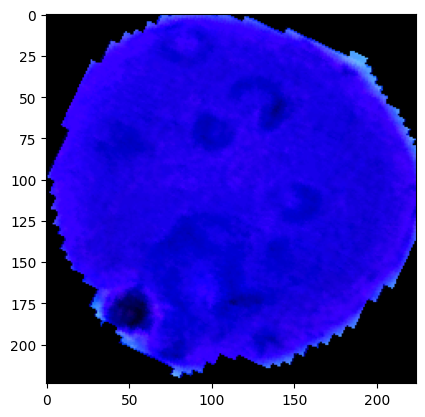

In [146]:
plt.imshow(image[0])
print(label[0])

In [147]:
image[0].shape

torch.Size([224, 224, 3])

In [148]:
image[0].view(-1, 16 * 56 * 56).shape

torch.Size([3, 50176])

In [149]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 56 * 56, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.reshape(-1, 16 * 56 * 56)  # Reshape for the fully connected layer
        x = self.classifier(x)
        return x

In [150]:
model = LeNet()

op=model(torch.zeros((3,3,224,224)))


In [151]:
op.shape

torch.Size([3, 1])

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3, )

In [153]:
device

device(type='cuda', index=0)

In [154]:
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [155]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch, 100*epoch_accuracy/len(val_dataset)))

In [156]:
# for i, (image, label) in enumerate(train_loader):
#     print(image.shape)

In [158]:
def train(EPOCHS):

  model.to(device)

  for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      label = torch.unsqueeze(label, -1)
      label = label.float()
      label = label.to(device)

      optimizer.zero_grad()

      output = model(image)

      loss = loss_fn(output, label)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

      step_length = int(len(train_loader)/2)

      if(i%step_length) == 0:
              print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_loader), loss.item()))
    print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss/len(train_loader)))

    get_accuracy(epoch)


In [159]:
train(20)

Epoch Number: 1, step: [0|689] ----> Loss: 0.597385585308075
Epoch Number: 1, step: [344|689] ----> Loss: 0.06672168523073196
Epoch Number: 1, step: [688|689] ----> Loss: 0.016881773248314857
Loss for epoch Number 1 is :0.13487880782687872
The Validation Accuracy for this epoch:0 is:100.0 
Epoch Number: 2, step: [0|689] ----> Loss: 0.016385391354560852
Epoch Number: 2, step: [344|689] ----> Loss: 0.0
Epoch Number: 2, step: [688|689] ----> Loss: 0.0
Loss for epoch Number 2 is :5.543675476228281e-05
The Validation Accuracy for this epoch:1 is:100.0 
Epoch Number: 3, step: [0|689] ----> Loss: 0.0
Epoch Number: 3, step: [344|689] ----> Loss: 0.0
Epoch Number: 3, step: [688|689] ----> Loss: 0.0
Loss for epoch Number 3 is :7.569531262077756e-11
The Validation Accuracy for this epoch:2 is:100.0 
Epoch Number: 4, step: [0|689] ----> Loss: 0.0
Epoch Number: 4, step: [344|689] ----> Loss: 0.0
Epoch Number: 4, step: [688|689] ----> Loss: 0.0
Loss for epoch Number 4 is :1.3517020110853133e-10
The 

In [264]:
image = cv2.imread('data/single_prediction/Uninfected.png')


In [265]:
image.shape

(157, 139, 3)

In [266]:
image_pil = Image.fromarray(image)
image = transform(image_pil)
image=image.detach().numpy()
image = image[None, :, :, :]

In [267]:
image=torch.tensor(image)
image.shape

torch.Size([1, 3, 224, 224])

In [261]:
# image = torch.permute(image, (0,3,1,2))

In [263]:
image = image.to(device)

In [268]:
image.shape

torch.Size([1, 3, 224, 224])

In [189]:
for i, (image, label) in enumerate(train_loader):
      image = torch.permute(image, (0,3,1,2))
    #   image = image.to(device)
      print(image.shape)
      break


torch.Size([32, 3, 224, 224])


In [226]:
dummy_input=torch.randn(1, 3, 224, 224)
dummy_input=dummy_input.to(device)
torch.onnx.export(model, dummy_input, 'models/Lenet_malaria_detection.onnx', export_params=True, opset_version=11, do_constant_folding=True)

In [219]:
op=model(image)

In [220]:
op

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [227]:
import onnx
from onnx2pytorch import ConvertModel

In [250]:
onnx_model = onnx.load("models/Lenet_malaria_detection.onnx")

pytorch_model = ConvertModel(onnx_model)

In [238]:
image.size()

torch.Size([1, 3, 224, 224])

In [251]:
pytorch_model.eval()

ConvertModel(
  (Conv_/feature_extractor/feature_extractor.0/Conv_output_0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_/feature_extractor/feature_extractor.2/Relu_output_0): ReLU(inplace=True)
  (MaxPool_/feature_extractor/feature_extractor.3/MaxPool_output_0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (Conv_/feature_extractor/feature_extractor.5/Conv_output_0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_/feature_extractor/feature_extractor.7/Relu_output_0): ReLU(inplace=True)
  (MaxPool_/feature_extractor/feature_extractor.8/MaxPool_output_0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (Constant_/Constant_output_0): Constant(constant=tensor([   -1, 50176]))
  (Reshape_/Reshape_output_0): Reshape(shape=None)
  (Gemm_/classifier/classifier.0/Gemm_output_0): Linear(in_features=50176, out_features=100, bias=True)
  (BatchN

In [249]:
cudaimage=img.to(device)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [269]:
model(image)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [243]:
model(cudaimage)

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [244]:
cuda_model_onnx=pytorch_model.to(device)

In [245]:
cuda_model_onnx(cudaimage)

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)